In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from google.cloud import bigquery
from google.cloud import bigquery
from google.oauth2 import service_account

In [3]:
#read csv to dataframe
weather_df = pd.read_csv('./data/noaa_weather_data.csv', index_col='DATE')

In [4]:
#find ercentage of missing casses per column
weather_df.apply(pd.isnull).sum()/weather_df.shape[0]

STATION      0.000000
NAME         0.000000
LATITUDE     0.000000
LONGITUDE    0.000000
ELEVATION    0.000000
ACMH         0.728780
ACSH         0.643611
AWND         0.446175
DAPR         0.999848
FMTM         0.654719
MDPR         0.999844
PGTM         0.509315
PRCP         0.062231
PSUN         0.841287
SNOW         0.175092
SNWD         0.188184
TAVG         0.696438
TMAX         0.037008
TMIN         0.048648
TOBS         0.950903
TSUN         0.676002
WDF1         0.861331
WDF2         0.593750
WDF5         0.599906
WDFG         0.733830
WDFM         0.806142
WESD         0.784235
WSF1         0.861312
WSF2         0.593974
WSF5         0.599830
WSFG         0.731621
WSFM         0.806112
WT01         0.734176
WT02         0.958391
WT03         0.947530
WT04         0.990908
WT05         0.983762
WT06         0.992927
WT07         0.996840
WT08         0.903149
WT09         0.994007
WT10         0.999916
WT11         0.999403
WT12         0.999992
WT13         0.922531
WT14      

In [5]:
#rename and filter columns which can be useful
core_weather_df = weather_df[['NAME','PRCP', 'SNOW','SNWD', 'TMAX','TMIN']].copy()
core_weather_df.columns = ['name','precip', 'snow', 'snow_depth', 'temp_max','temp_min']
core_weather_df.head()

,name,precip,snow,snow_depth,temp_max,temp_min
DATE,,,,,,
1964-01-01,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",0.01,0.1,8.0,8.0,-13.0
1964-01-02,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",0.00,0.0,8.0,-6.0,-20.0
1964-01-03,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",0.00,0.0,8.0,-4.0,-21.0
1964-01-04,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",0.00,0.0,8.0,15.0,-18.0
1964-01-05,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",0.02,1.0,9.0,6.0,-23.0


In [6]:
#find missing data points for the precip column to determine patterns of missing data and the best way to fill the missing data points
core_weather_df[pd.isnull(core_weather_df['precip'])].head()

,name,precip,snow,snow_depth,temp_max,temp_min
DATE,,,,,,
2023-02-24,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",NaN,NaN,NaN,NaN,NaN
1997-01-01,"SITKA AIRPORT, AK US",NaN,NaN,NaN,24.0,13.0
1997-01-02,"SITKA AIRPORT, AK US",NaN,NaN,NaN,24.0,12.0
1997-01-03,"SITKA AIRPORT, AK US",NaN,NaN,NaN,32.0,23.0
1997-01-04,"SITKA AIRPORT, AK US",NaN,NaN,NaN,37.0,30.0


In [7]:
#fill missing data points
core_weather_df['precip'] = core_weather_df['precip'].fillna(0)
core_weather_df['snow'] = core_weather_df['snow'].fillna(0)
core_weather_df['snow_depth'] = core_weather_df['snow_depth'].fillna(0)
#map the name to a number variable to be used as a predictor
core_weather_df['name_num'] = pd.factorize(core_weather_df['name'])[0]
#'ffill' ('forward fill') fills the value in with the value from the previous date this will apply to the temp_min/max columns since the others have already been filled in
core_weather_df = core_weather_df.fillna(method='ffill')
core_weather_df.tail()

,name,precip,snow,snow_depth,temp_max,temp_min,name_num
DATE,,,,,,,
2023-02-20,"ORLANDO EXECUTIVE AIRPORT, FL US",0.0,0.0,0.0,84.0,61.0,12
2023-02-21,"ORLANDO EXECUTIVE AIRPORT, FL US",0.0,0.0,0.0,85.0,65.0,12
2023-02-22,"ORLANDO EXECUTIVE AIRPORT, FL US",0.0,0.0,0.0,87.0,60.0,12
2023-02-23,"ORLANDO EXECUTIVE AIRPORT, FL US",0.0,0.0,0.0,88.0,66.0,12
2023-02-24,"ORLANDO EXECUTIVE AIRPORT, FL US",0.0,0.0,0.0,88.0,64.0,12


In [8]:
#check the percentage of null values to make sure there are none left
core_weather_df.apply(pd.isnull).sum()/core_weather_df.shape[0]

name          0.0
precip        0.0
snow          0.0
snow_depth    0.0
temp_max      0.0
temp_min      0.0
name_num      0.0
dtype: float64

In [9]:

#change date index to a datetime data type
core_weather_df.index = pd.to_datetime(core_weather_df.index)

#check data types 
print(core_weather_df.dtypes)
print(core_weather_df.index)

name           object
precip        float64
snow          float64
snow_depth    float64
temp_max      float64
temp_min      float64
name_num        int64
dtype: object
DatetimeIndex(['1964-01-01', '1964-01-02', '1964-01-03', '1964-01-04',
               '1964-01-05', '1964-01-06', '1964-01-07', '1964-01-08',
               '1964-01-09', '1964-01-10',
               ...
               '2023-02-15', '2023-02-16', '2023-02-17', '2023-02-18',
               '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22',
               '2023-02-23', '2023-02-24'],
              dtype='datetime64[ns]', name='DATE', length=262971, freq=None)


In [10]:
#check for 9999 values because the data source noted that 9999 values are missing or incorrect
core_weather_df.apply(lambda x: (x==9999).sum())

name          0
precip        0
snow          0
snow_depth    0
temp_max      0
temp_min      0
name_num      0
dtype: int64

name
ALBUQUERQUE INTERNATIONAL AIRPORT, NM US     AxesSubplot(0.125,0.11;0.775x0.77)
BANGOR INTERNATIONAL AIRPORT, ME US           AxesSubplot(0.125,0.2;0.775x0.68)
FAIRBANKS INTERNATIONAL AIRPORT, AK US       AxesSubplot(0.125,0.11;0.775x0.77)
KAHULUI AIRPORT, HI US                       AxesSubplot(0.125,0.11;0.775x0.77)
KALISPELL GLACIER AIRPORT, MT US             AxesSubplot(0.125,0.11;0.775x0.77)
LYNCHBURG REGIONAL AIRPORT, VA US            AxesSubplot(0.125,0.11;0.775x0.77)
MILWAUKEE MITCHELL AIRPORT, WI US            AxesSubplot(0.125,0.11;0.775x0.77)
ORLANDO EXECUTIVE AIRPORT, FL US              AxesSubplot(0.125,0.2;0.775x0.68)
PHILADELPHIA INTERNATIONAL AIRPORT, PA US    AxesSubplot(0.125,0.11;0.775x0.77)
PORTLAND INTERNATIONAL AIRPORT, OR US        AxesSubplot(0.125,0.11;0.775x0.77)
SITKA AIRPORT, AK US                          AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

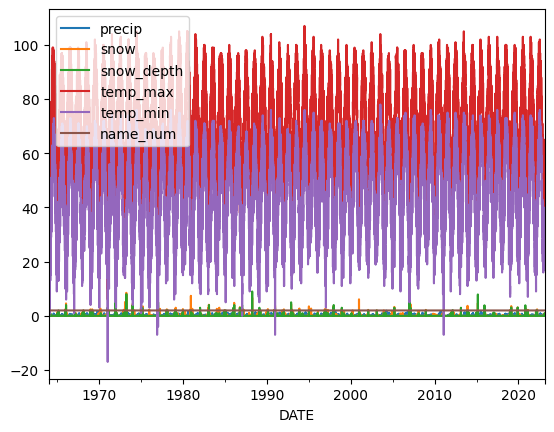

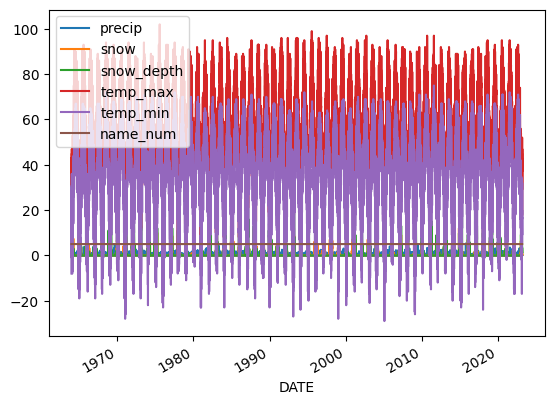

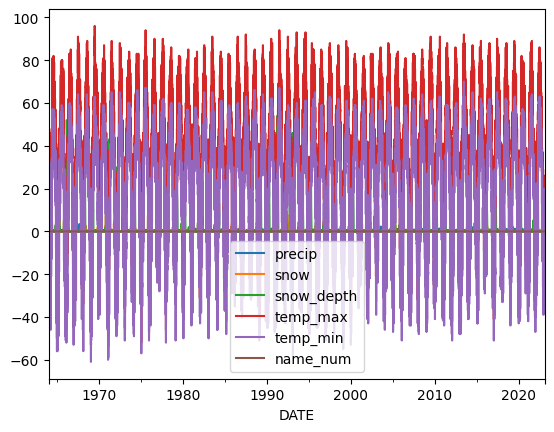

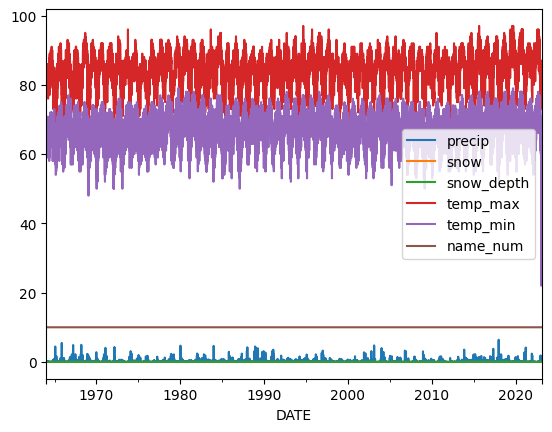

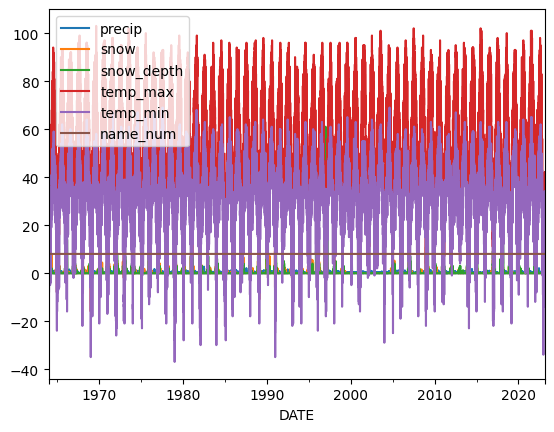

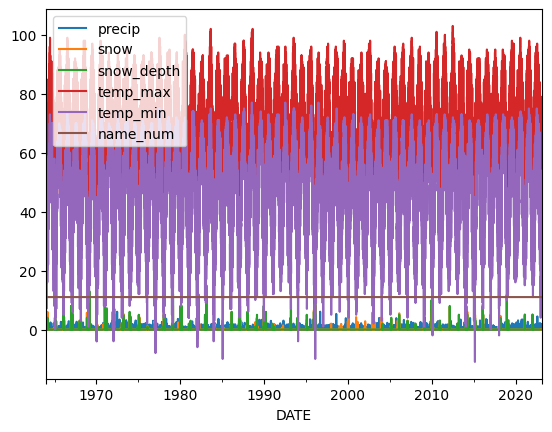

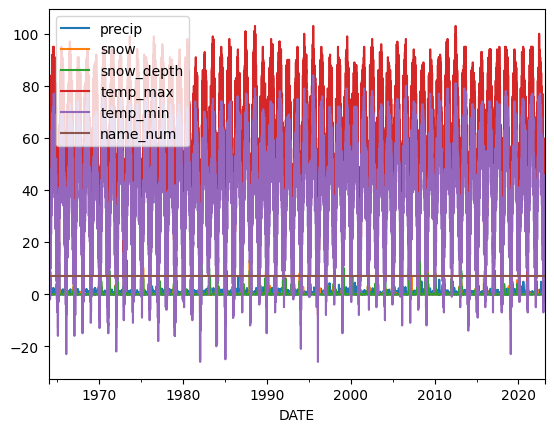

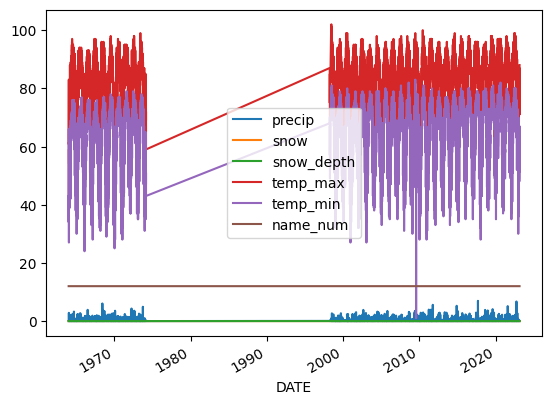

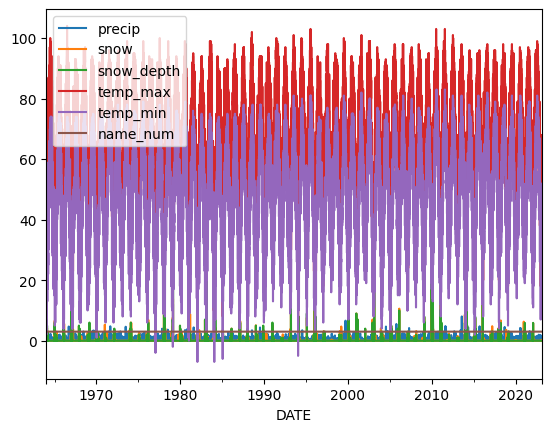

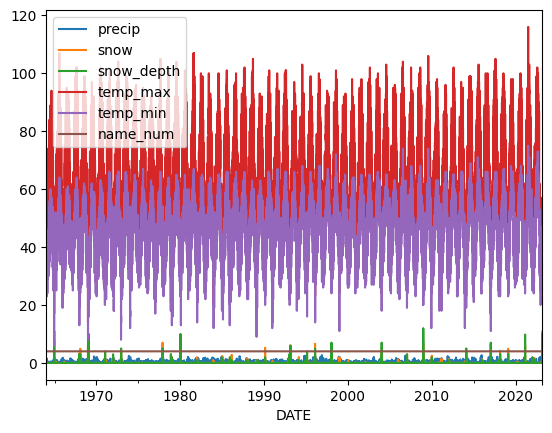

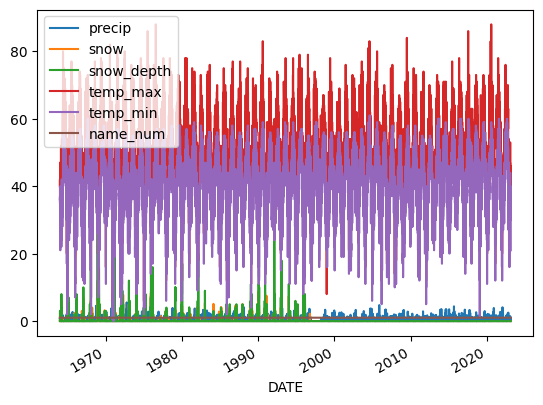

In [11]:
#make a visual representation of the data
core_weather_df = core_weather_df[core_weather_df.name.isin(['BEMIDJI, MN US', 'SHARJAH INTER. AIRP, AE']) == False]
core_weather_df.groupby(by='name').plot()

In [12]:
#create a column 'target_temp_max' by shifting all values in the temp_max column back a day...creates a column based on temperatures from tomorrows temps
# core_weather_df['target_temp_max'] = core_weather_df.shift(-1)['temp_max']
core_weather_df['target_temp_max_day_1'] = core_weather_df.groupby('name')['temp_max'].shift(-1)
core_weather_df['target_temp_max_day_2'] = core_weather_df.groupby('name')['target_temp_max_day_1'].shift(-1)
core_weather_df['target_temp_max_day_3'] = core_weather_df.groupby('name')['target_temp_max_day_2'].shift(-1)
core_weather_df['target_temp_max_day_4'] = core_weather_df.groupby('name')['target_temp_max_day_3'].shift(-1)
core_weather_df['target_temp_max_day_5'] = core_weather_df.groupby('name')['target_temp_max_day_4'].shift(-1)
core_weather_df['target_temp_max_day_6'] = core_weather_df.groupby('name')['target_temp_max_day_5'].shift(-1)
core_weather_df['target_temp_max_day_7'] = core_weather_df.groupby('name')['target_temp_max_day_6'].shift(-1)
core_weather_df['target_temp_max_day_8'] = core_weather_df.groupby('name')['target_temp_max_day_7'].shift(-1)
core_weather_df['target_temp_max_day_9'] = core_weather_df.groupby('name')['target_temp_max_day_8'].shift(-1)
core_weather_df['target_temp_max_day_10'] = core_weather_df.groupby('name')['target_temp_max_day_9'].shift(-1)
#remove the last row since its a NaN value cuz that value would be in the future
# core_weather_df = core_weather_df.iloc[:-1].copy()
core_weather_df = core_weather_df.dropna()
core_weather_df['date'] = core_weather_df.index
core_weather_df['date']=core_weather_df['date'].astype(str)

core_weather_df.info(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 228601 entries, 1964-01-01 to 2023-02-14
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   name                    228601 non-null  object 
 1   precip                  228601 non-null  float64
 2   snow                    228601 non-null  float64
 3   snow_depth              228601 non-null  float64
 4   temp_max                228601 non-null  float64
 5   temp_min                228601 non-null  float64
 6   name_num                228601 non-null  int64  
 7   target_temp_max_day_1   228601 non-null  float64
 8   target_temp_max_day_2   228601 non-null  float64
 9   target_temp_max_day_3   228601 non-null  float64
 10  target_temp_max_day_4   228601 non-null  float64
 11  target_temp_max_day_5   228601 non-null  float64
 12  target_temp_max_day_6   228601 non-null  float64
 13  target_temp_max_day_7   228601 non-null  float64
 14  targ

In [13]:
#using Ridge regression to minimize overfitting
regression = Ridge(alpha=.1)
predictors = ['precip','snow','snow_depth','temp_max','temp_min']
#training set includes all data before and including dec 12th 2021, this is teh set that is used to train the model to predict future data
training_set = core_weather_df.loc[:'2021-12-31']
#test set includes all data after and including jan 1st 2022
test_set = core_weather_df.loc['2022-01-01':]

In [14]:
display(test_set)

,name,precip,snow,snow_depth,temp_max,temp_min,name_num,target_temp_max_day_1,target_temp_max_day_2,target_temp_max_day_3,target_temp_max_day_4,target_temp_max_day_5,target_temp_max_day_6,target_temp_max_day_7,target_temp_max_day_8,target_temp_max_day_9,target_temp_max_day_10,date
DATE,,,,,,,,,,,,,,,,,,
2022-01-01,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",0.00,0.1,33.9,-7.0,-17.0,0,-16.0,-14.0,-19.0,-26.0,-6.0,-26.0,-30.0,2.0,3.0,7.0,2022-01-01
2022-01-02,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",0.00,0.0,33.1,-16.0,-47.0,0,-14.0,-19.0,-26.0,-6.0,-26.0,-30.0,2.0,3.0,7.0,12.0,2022-01-02
2022-01-03,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",0.00,0.0,33.1,-14.0,-45.0,0,-19.0,-26.0,-6.0,-26.0,-30.0,2.0,3.0,7.0,12.0,21.0,2022-01-03
2022-01-04,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",0.00,0.0,33.1,-19.0,-37.0,0,-26.0,-6.0,-26.0,-30.0,2.0,3.0,7.0,12.0,21.0,20.0,2022-01-04
2022-01-05,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",0.00,0.0,33.1,-26.0,-38.0,0,-6.0,-26.0,-30.0,2.0,3.0,7.0,12.0,21.0,20.0,7.0,2022-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10,"ORLANDO EXECUTIVE AIRPORT, FL US",0.21,0.0,0.0,84.0,66.0,12,84.0,72.0,71.0,77.0,82.0,85.0,87.0,71.0,84.0,84.0,2023-02-10
2023-02-11,"ORLANDO EXECUTIVE AIRPORT, FL US",0.01,0.0,0.0,84.0,67.0,12,72.0,71.0,77.0,82.0,85.0,87.0,71.0,84.0,84.0,85.0,2023-02-11
2023-02-12,"ORLANDO EXECUTIVE AIRPORT, FL US",0.02,0.0,0.0,72.0,54.0,12,71.0,77.0,82.0,85.0,87.0,71.0,84.0,84.0,85.0,87.0,2023-02-12


In [15]:
#train the model based on teh predictors
regression.fit(training_set[predictors], training_set['target_temp_max_day_1'])
predictions = regression.predict(test_set[predictors])

#use mean absolute error subtracts the actual from the predictions, take the abs value and then find the average across all teh predictions
print(mean_absolute_error(test_set['target_temp_max_day_1'],predictions)) #returns 4.68 which means that the prediction was off by an average of 4.68 degrees

4.871114965598422


In [16]:
#combine df to include actual values and the predicted values
combined_df = pd.concat([test_set[['name','target_temp_max_day_1']], pd.Series(predictions, index = test_set.index)], axis=1)
combined_df.columns = ['name','actual','predictions']
combined_df.head(50)

,name,actual,predictions
DATE,,,
2022-01-01,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-16.0,-4.864060
2022-01-02,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-14.0,-16.366461
2022-01-03,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-19.0,-14.435751
2022-01-04,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-26.0,-17.472692
2022-01-05,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-6.0,-23.404100
2022-01-06,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-26.0,-5.473795
2022-01-07,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-30.0,-23.266420
2022-01-08,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",2.0,-26.990161
2022-01-09,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",3.0,-0.229186


In [17]:
#find values that the model predicted incorectly
combined_df['diff'] = (combined_df['actual']-combined_df['predictions']).abs()
combined_df.sort_values('diff', ascending=False).head()
# combined_df['date'] = combined_df.index
combined_df.head()

,name,actual,predictions,diff
DATE,,,,
2022-01-01,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-16.0,-4.864060,11.135940
2022-01-02,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-14.0,-16.366461,2.366461
2022-01-03,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-19.0,-14.435751,4.564249
2022-01-04,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-26.0,-17.472692,8.527308
2022-01-05,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-6.0,-23.404100,17.404100


In [18]:
PROJECT_ID = "deb-01-372116"
DATASET_ID = "Weather_Forecaster"
DAILY_TABLE_ID = "model_test"

SCHEMA = [
            # indexes are written if only named in the schema
            bigquery.SchemaField('name', 'STRING', mode='REQUIRED'),
            bigquery.SchemaField('actual', 'FLOAT64', mode='NULLABLE'),
            bigquery.SchemaField('predictions', 'FLOAT64', mode='NULLABLE'),
            bigquery.SchemaField('diff', 'FLOAT64', mode='NULLABLE'),
            # bigquery.SchemaField('Date', 'DATETIME', mode='NULLABLE'),
            bigquery.SchemaField('DATE', 'DATETIME', mode='NULLABLE')
        ]

#change the date column back to a datetime dtype
# df = pd.DataFrame(data)

client = bigquery.Client()

try:
    dataset_ref = client.dataset(DATASET_ID)
    dataset = client.get_dataset(dataset_ref)
except:
    dataset_ref = client.dataset(DATASET_ID)
    dataset = bigquery.Dataset(dataset_ref)
    # dataset.location = "US"
    dataset = client.create_dataset(dataset)

table_ref = dataset.table(DAILY_TABLE_ID)

try:
    client.get_table(table_ref)
except:
    table = bigquery.Table(table_ref, schema=SCHEMA)
    table = client.create_table(table)

job_config = bigquery.LoadJobConfig(write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE)
job = client.load_table_from_dataframe(combined_df, table_ref, job_config=job_config)
job.result()

LoadJob<project=deb-01-372116, location=US, id=3043ccb8-1a4e-48c3-a499-dcd2852c1322>

name
ALBUQUERQUE INTERNATIONAL AIRPORT, NM US     AxesSubplot(0.125,0.11;0.775x0.77)
BANGOR INTERNATIONAL AIRPORT, ME US          AxesSubplot(0.125,0.11;0.775x0.77)
FAIRBANKS INTERNATIONAL AIRPORT, AK US       AxesSubplot(0.125,0.11;0.775x0.77)
KAHULUI AIRPORT, HI US                       AxesSubplot(0.125,0.11;0.775x0.77)
KALISPELL GLACIER AIRPORT, MT US             AxesSubplot(0.125,0.11;0.775x0.77)
LYNCHBURG REGIONAL AIRPORT, VA US            AxesSubplot(0.125,0.11;0.775x0.77)
MILWAUKEE MITCHELL AIRPORT, WI US            AxesSubplot(0.125,0.11;0.775x0.77)
ORLANDO EXECUTIVE AIRPORT, FL US             AxesSubplot(0.125,0.11;0.775x0.77)
PHILADELPHIA INTERNATIONAL AIRPORT, PA US    AxesSubplot(0.125,0.11;0.775x0.77)
PORTLAND INTERNATIONAL AIRPORT, OR US        AxesSubplot(0.125,0.11;0.775x0.77)
SITKA AIRPORT, AK US                          AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

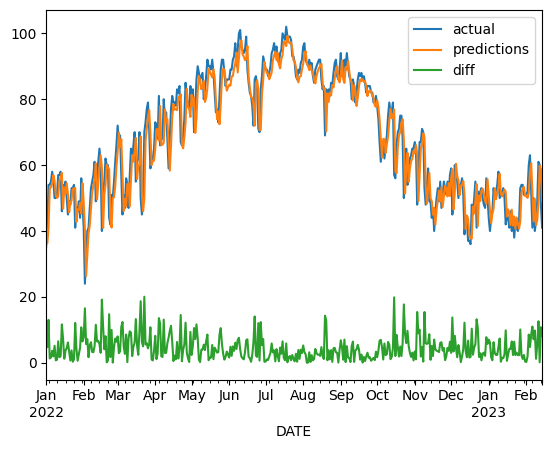

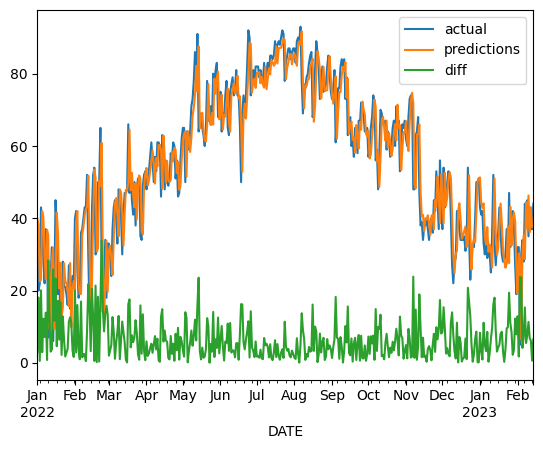

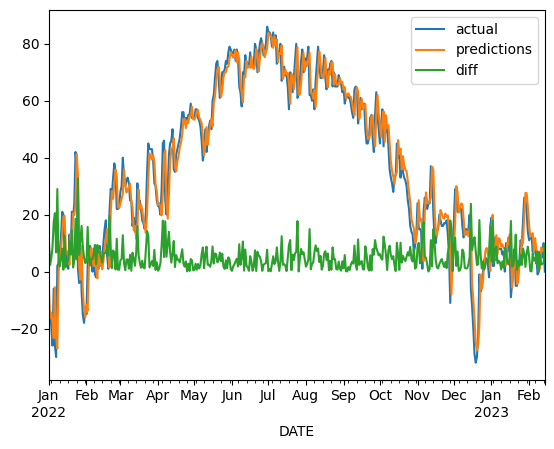

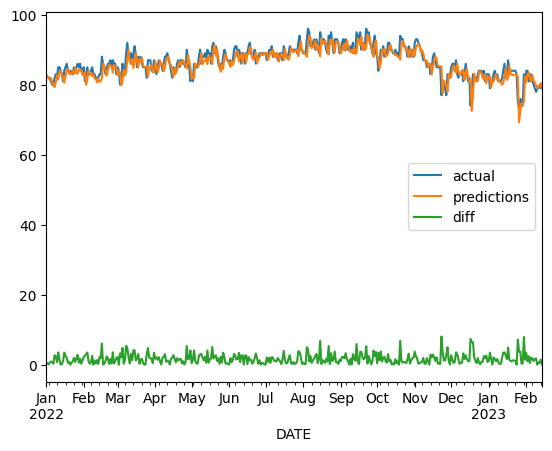

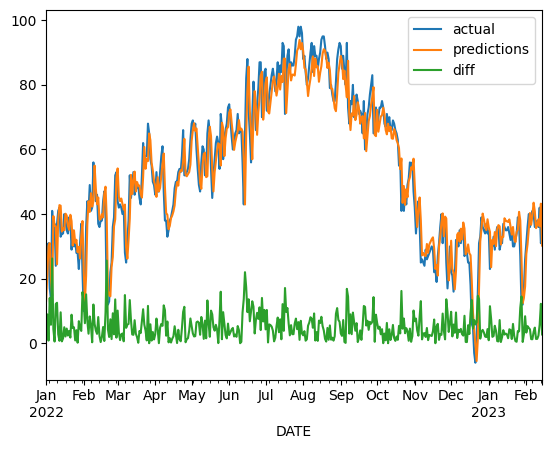

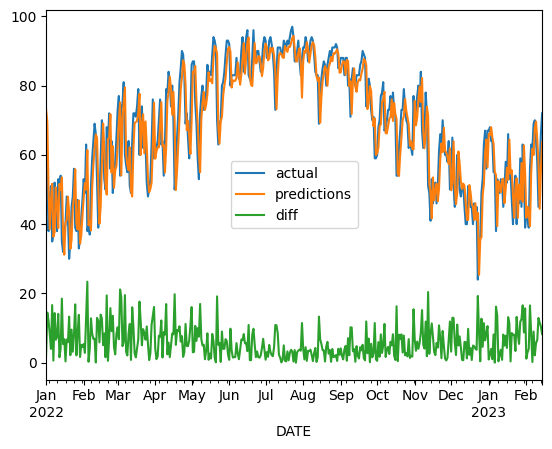

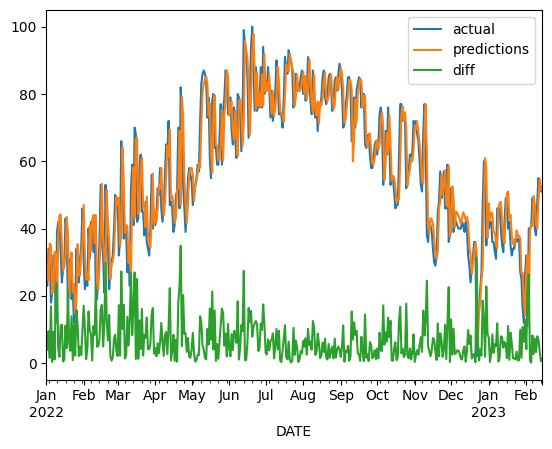

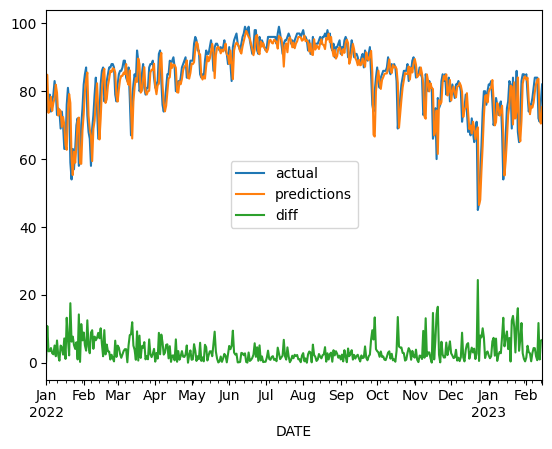

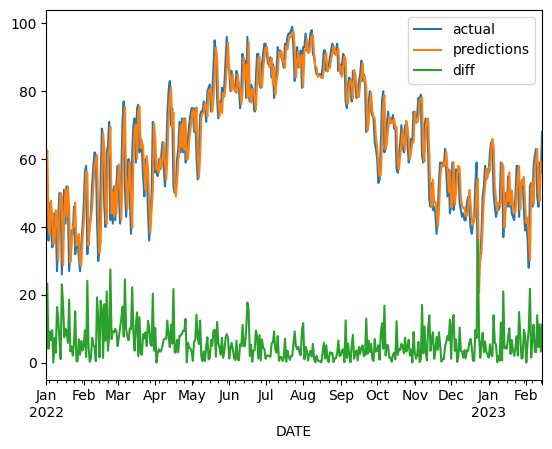

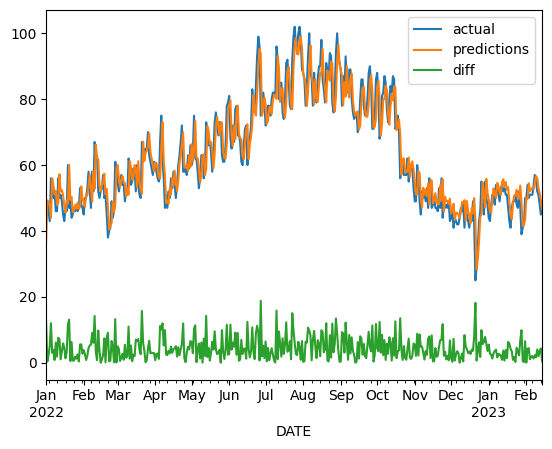

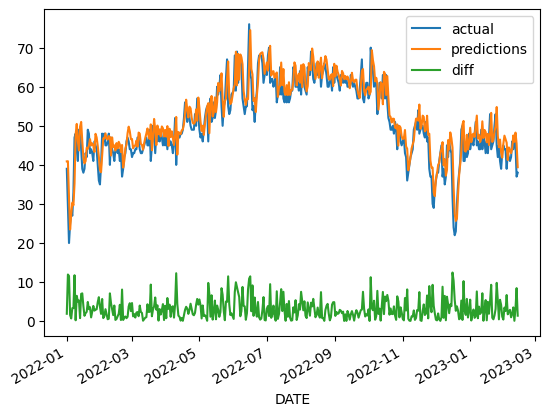

In [19]:
combined_df.groupby(by='name').plot()

In [20]:
#regression coeficients indicate the effect each variable has on the temperature tomorrow.
#For example, precip has a coeficient of '-1.56' therefore, precip is an indicator of a colder temp_max tomorrow 

predictors = ['precip','snow','snow_depth','temp_max','temp_min']
print(regression.coef_)

[-1.55551237 -0.3804174  -0.04877879  0.82767547  0.13767954]


In [21]:
def create_predictions_1_day(predictors, core_weather_df, regression):

    training_set = core_weather_df.loc[:'2021-12-31']
    test_set = core_weather_df.loc['2022-01-01':]
    
    regression.fit(training_set[predictors], training_set['target_temp_max_day_1'])
    predictions = regression.predict(test_set[predictors])
    error = mean_absolute_error(test_set['target_temp_max_day_1'],predictions)

    combined_df = pd.concat([test_set[['name','target_temp_max_day_1']], pd.Series(predictions, index = test_set.index)], axis=1)
    combined_df.columns = ['name','actual','predictions']

    return error, combined_df

def create_predictions_2_days(predictors, core_weather_df, regression):
    training_set = core_weather_df.loc[:'2021-12-31']
    test_set = core_weather_df.loc['2022-01-01':]
    regression.fit(training_set[predictors], training_set['target_temp_max_day_2'])
    predictions = regression.predict(test_set[predictors])
    error = mean_absolute_error(test_set['target_temp_max_day_2'],predictions)
    combined_df = pd.concat([test_set[['name','target_temp_max_day_2']], pd.Series(predictions, index = test_set.index)], axis=1)
    combined_df.columns = ['name','actual','predictions']

    return error, combined_df

def create_predictions_3_days(predictors, core_weather_df, regression):
    training_set = core_weather_df.loc[:'2021-12-31']
    test_set = core_weather_df.loc['2022-01-01':]
    regression.fit(training_set[predictors], training_set['target_temp_max_day_3'])
    predictions = regression.predict(test_set[predictors])
    error = mean_absolute_error(test_set['target_temp_max_day_3'],predictions)
    combined_df = pd.concat([test_set[['name','target_temp_max_day_3']], pd.Series(predictions, index = test_set.index)], axis=1)
    combined_df.columns = ['name','actual','predictions']

    return error, combined_df

def create_predictions_4_days(predictors, core_weather_df, regression):
    training_set = core_weather_df.loc[:'2021-12-31']
    test_set = core_weather_df.loc['2022-01-01':]
    regression.fit(training_set[predictors], training_set['target_temp_max_day_4'])
    predictions = regression.predict(test_set[predictors])
    error = mean_absolute_error(test_set['target_temp_max_day_4'],predictions)
    combined_df = pd.concat([test_set[['name','target_temp_max_day_4']], pd.Series(predictions, index = test_set.index)], axis=1)
    combined_df.columns = ['name','actual','predictions']

    return error, combined_df

def create_predictions_5_days(predictors, core_weather_df, regression):
    training_set = core_weather_df.loc[:'2021-12-31']
    test_set = core_weather_df.loc['2022-01-01':]
    regression.fit(training_set[predictors], training_set['target_temp_max_day_5'])
    predictions = regression.predict(test_set[predictors])
    error = mean_absolute_error(test_set['target_temp_max_day_5'],predictions)
    combined_df = pd.concat([test_set[['name','target_temp_max_day_5']], pd.Series(predictions, index = test_set.index)], axis=1)
    combined_df.columns = ['name','actual','predictions']

    return error, combined_df

def create_predictions_6_days(predictors, core_weather_df, regression):
    training_set = core_weather_df.loc[:'2021-12-31']
    test_set = core_weather_df.loc['2022-01-01':]
    regression.fit(training_set[predictors], training_set['target_temp_max_day_6'])
    predictions = regression.predict(test_set[predictors])
    error = mean_absolute_error(test_set['target_temp_max_day_6'],predictions)
    combined_df = pd.concat([test_set[['name','target_temp_max_day_6']], pd.Series(predictions, index = test_set.index)], axis=1)
    combined_df.columns = ['name','actual','predictions']

    return error, combined_df

def create_predictions_7_days(predictors, core_weather_df, regression):
    training_set = core_weather_df.loc[:'2021-12-31']
    test_set = core_weather_df.loc['2022-01-01':]
    regression.fit(training_set[predictors], training_set['target_temp_max_day_7'])
    predictions = regression.predict(test_set[predictors])
    error = mean_absolute_error(test_set['target_temp_max_day_7'],predictions)
    combined_df = pd.concat([test_set[['name','target_temp_max_day_7']], pd.Series(predictions, index = test_set.index)], axis=1)
    combined_df.columns = ['name','actual','predictions']

    return error, combined_df

def create_predictions_8_days(predictors, core_weather_df, regression):
    training_set = core_weather_df.loc[:'2021-12-31']
    test_set = core_weather_df.loc['2022-01-01':]
    regression.fit(training_set[predictors], training_set['target_temp_max_day_8'])
    predictions = regression.predict(test_set[predictors])
    error = mean_absolute_error(test_set['target_temp_max_day_8'],predictions)
    combined_df = pd.concat([test_set[['name','target_temp_max_day_8']], pd.Series(predictions, index = test_set.index)], axis=1)
    combined_df.columns = ['name','actual','predictions']

    return error, combined_df

def create_predictions_9_days(predictors, core_weather_df, regression):
    training_set = core_weather_df.loc[:'2021-12-31']
    test_set = core_weather_df.loc['2022-01-01':]
    regression.fit(training_set[predictors], training_set['target_temp_max_day_9'])
    predictions = regression.predict(test_set[predictors])
    error = mean_absolute_error(test_set['target_temp_max_day_9'],predictions)
    combined_df = pd.concat([test_set[['name','target_temp_max_day_9']], pd.Series(predictions, index = test_set.index)], axis=1)
    combined_df.columns = ['name','actual','predictions']

    return error, combined_df

def create_predictions_10_days(predictors, core_weather_df, regression):
    training_set = core_weather_df.loc[:'2021-12-31']
    test_set = core_weather_df.loc['2022-01-01':]
    regression.fit(training_set[predictors], training_set['target_temp_max_day_10'])
    predictions = regression.predict(test_set[predictors])
    error = mean_absolute_error(test_set['target_temp_max_day_10'],predictions)
    combined_df = pd.concat([test_set[['name','target_temp_max_day_10']], pd.Series(predictions, index = test_set.index)], axis=1)
    combined_df.columns = ['name','actual','predictions']

    return error, combined_df


In [22]:
#uses rolling mean to calculate month max...rolling mean looks back 30 days and assigns the value to the month max variable (will create NaN for the first 30 days which need ot be removed)
core_weather_df['month_max'] = core_weather_df['temp_max'].rolling(30).mean()
#need to remove the first 30 rows to get rid of the NaN values
core_weather_df = core_weather_df.iloc[30:,:].copy()
core_weather_df[['name','month_max']].head()

,name,month_max
DATE,,
1964-01-31,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-7.366667
1964-02-01,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-6.600000
1964-02-02,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-5.466667
1964-02-03,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-5.633333
1964-02-04,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-5.300000


In [23]:
#to find how different the temperature was from the monthly mean:
core_weather_df['month_day_max'] = core_weather_df['month_max']/ core_weather_df['temp_max']
#create another predictor based on 
core_weather_df['max_min'] = abs(core_weather_df['temp_max']/ core_weather_df['temp_min'])

display(core_weather_df[['name','temp_max','temp_min','month_max','month_day_max','max_min']])


,name,temp_max,temp_min,month_max,month_day_max,max_min
DATE,,,,,,
1964-01-31,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",3.0,-9.0,-7.366667,-2.455556,0.333333
1964-02-01,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",17.0,-5.0,-6.600000,-0.388235,3.400000
1964-02-02,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",30.0,4.0,-5.466667,-0.182222,7.500000
1964-02-03,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",10.0,-5.0,-5.633333,-0.563333,2.000000
1964-02-04,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",16.0,-20.0,-5.300000,-0.331250,0.800000
...,...,...,...,...,...,...
2023-02-10,"ORLANDO EXECUTIVE AIRPORT, FL US",84.0,66.0,76.266667,0.907937,1.272727
2023-02-11,"ORLANDO EXECUTIVE AIRPORT, FL US",84.0,67.0,76.500000,0.910714,1.253731
2023-02-12,"ORLANDO EXECUTIVE AIRPORT, FL US",72.0,54.0,76.633333,1.064352,1.333333


In [24]:
# predictors = ['precip','snow','snow_depth','temp_max','temp_min','month_day_max','month_max','max_min','name_num']
predictors = ['precip','snow','snow_depth','temp_max','month_day_max','month_max','name_num']
#data set contains 737 infinite numbers which need to be turned to NaN and removed
count = np.isinf(core_weather_df[['temp_max','temp_min','month_max','month_day_max','max_min']]).values.sum()
#change infinity values to NaN then drop na
core_weather_df = core_weather_df.replace([np.inf, -np.inf], np.nan).dropna()

# print(mean_absolute_error(test_set['target_temp_max'],predictions))
print(create_predictions_1_day(predictors, core_weather_df, regression))
print(regression.coef_)

(4.643510015552295,                                               name  actual  predictions
DATE                                                                   
2022-01-01  FAIRBANKS INTERNATIONAL AIRPORT, AK US   -16.0    -1.364832
2022-01-02  FAIRBANKS INTERNATIONAL AIRPORT, AK US   -14.0    -8.027544
2022-01-03  FAIRBANKS INTERNATIONAL AIRPORT, AK US   -19.0    -6.569735
2022-01-04  FAIRBANKS INTERNATIONAL AIRPORT, AK US   -26.0   -10.622706
2022-01-05  FAIRBANKS INTERNATIONAL AIRPORT, AK US    -6.0   -16.305133
...                                            ...     ...          ...
2023-02-10        ORLANDO EXECUTIVE AIRPORT, FL US    84.0    82.014425
2023-02-11        ORLANDO EXECUTIVE AIRPORT, FL US    72.0    82.227467
2023-02-12        ORLANDO EXECUTIVE AIRPORT, FL US    71.0    73.201365
2023-02-13        ORLANDO EXECUTIVE AIRPORT, FL US    77.0    72.593854
2023-02-14        ORLANDO EXECUTIVE AIRPORT, FL US    82.0    77.248063

[4492 rows x 3 columns])
[-0.79680292 -0.38

In [25]:
#find predictors that are correlated with the values we are trying to predict
core_weather_df.corr()['temp_max']

precip                   -0.023570
snow                     -0.213669
snow_depth               -0.500731
temp_max                  1.000000
temp_min                  0.921935
name_num                  0.372825
target_temp_max_day_1     0.953775
target_temp_max_day_2     0.917863
target_temp_max_day_3     0.899523
target_temp_max_day_4     0.889256
target_temp_max_day_5     0.882429
target_temp_max_day_6     0.877086
target_temp_max_day_7     0.872555
target_temp_max_day_8     0.868851
target_temp_max_day_9     0.865457
target_temp_max_day_10    0.862439
month_max                 0.915381
month_day_max            -0.056937
max_min                  -0.196156
Name: temp_max, dtype: float64

In [26]:
#find values that the model predicted incorectly
combined_df['diff'] = (combined_df['actual']-combined_df['predictions']).abs()
combined_df.sort_values('diff', ascending=False).head()

,name,actual,predictions,diff
DATE,,,,
2022-12-23,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",18.0,54.287186,36.287186
2022-04-22,"MILWAUKEE MITCHELL AIRPORT, WI US",82.0,47.106412,34.893588
2022-02-23,"BANGOR INTERNATIONAL AIRPORT, ME US",27.0,60.867994,33.867994
2022-01-25,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",1.0,33.722330,32.722330
2022-12-22,"MILWAUKEE MITCHELL AIRPORT, WI US",2.0,33.330185,31.330185


In [27]:
#-------------------predicts two days in the future---------------------------------------------------------
print(create_predictions_1_day(predictors, core_weather_df, regression))
print(create_predictions_2_days(predictors, core_weather_df, regression))
print(create_predictions_3_days(predictors, core_weather_df, regression))
print(create_predictions_4_days(predictors, core_weather_df, regression))
print(create_predictions_5_days(predictors, core_weather_df, regression))
print(create_predictions_6_days(predictors, core_weather_df, regression))
print(create_predictions_7_days(predictors, core_weather_df, regression))
print(create_predictions_8_days(predictors, core_weather_df, regression))
print(create_predictions_9_days(predictors, core_weather_df, regression))
print(create_predictions_10_days(predictors, core_weather_df, regression))

(4.643510015552295,                                               name  actual  predictions
DATE                                                                   
2022-01-01  FAIRBANKS INTERNATIONAL AIRPORT, AK US   -16.0    -1.364832
2022-01-02  FAIRBANKS INTERNATIONAL AIRPORT, AK US   -14.0    -8.027544
2022-01-03  FAIRBANKS INTERNATIONAL AIRPORT, AK US   -19.0    -6.569735
2022-01-04  FAIRBANKS INTERNATIONAL AIRPORT, AK US   -26.0   -10.622706
2022-01-05  FAIRBANKS INTERNATIONAL AIRPORT, AK US    -6.0   -16.305133
...                                            ...     ...          ...
2023-02-10        ORLANDO EXECUTIVE AIRPORT, FL US    84.0    82.014425
2023-02-11        ORLANDO EXECUTIVE AIRPORT, FL US    72.0    82.227467
2023-02-12        ORLANDO EXECUTIVE AIRPORT, FL US    71.0    73.201365
2023-02-13        ORLANDO EXECUTIVE AIRPORT, FL US    77.0    72.593854
2023-02-14        ORLANDO EXECUTIVE AIRPORT, FL US    82.0    77.248063

[4492 rows x 3 columns])
(5.949278660540147

name
ALBUQUERQUE INTERNATIONAL AIRPORT, NM US     AxesSubplot(0.125,0.11;0.775x0.77)
BANGOR INTERNATIONAL AIRPORT, ME US          AxesSubplot(0.125,0.11;0.775x0.77)
FAIRBANKS INTERNATIONAL AIRPORT, AK US       AxesSubplot(0.125,0.11;0.775x0.77)
KAHULUI AIRPORT, HI US                       AxesSubplot(0.125,0.11;0.775x0.77)
KALISPELL GLACIER AIRPORT, MT US             AxesSubplot(0.125,0.11;0.775x0.77)
LYNCHBURG REGIONAL AIRPORT, VA US            AxesSubplot(0.125,0.11;0.775x0.77)
MILWAUKEE MITCHELL AIRPORT, WI US            AxesSubplot(0.125,0.11;0.775x0.77)
ORLANDO EXECUTIVE AIRPORT, FL US             AxesSubplot(0.125,0.11;0.775x0.77)
PHILADELPHIA INTERNATIONAL AIRPORT, PA US    AxesSubplot(0.125,0.11;0.775x0.77)
PORTLAND INTERNATIONAL AIRPORT, OR US        AxesSubplot(0.125,0.11;0.775x0.77)
SITKA AIRPORT, AK US                          AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

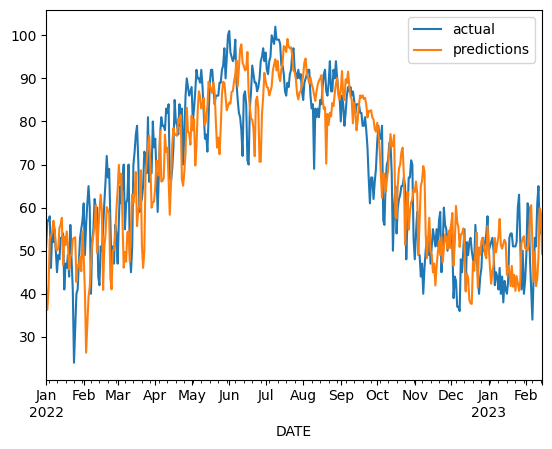

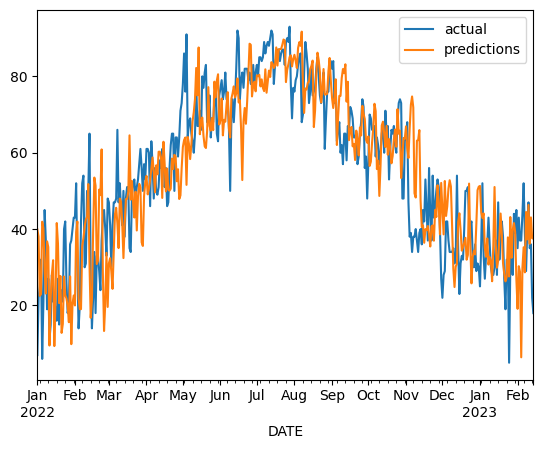

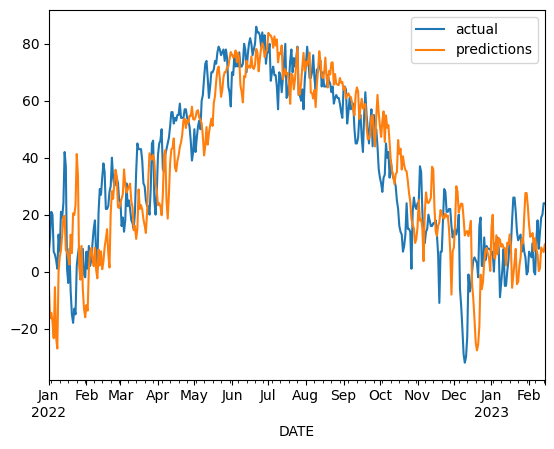

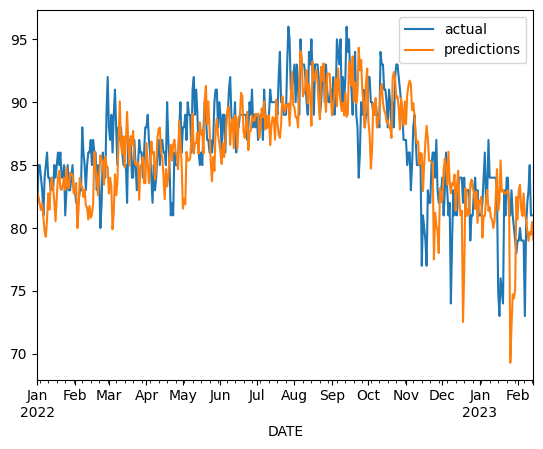

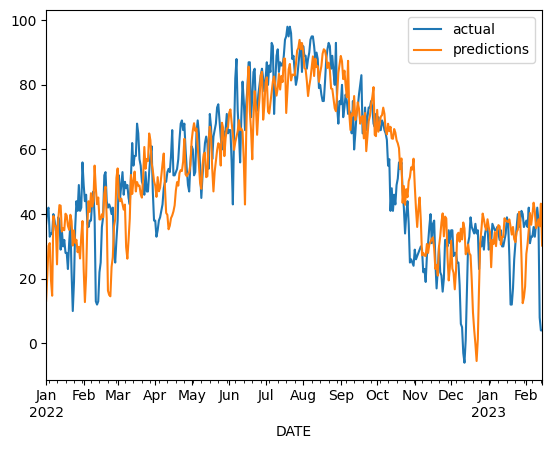

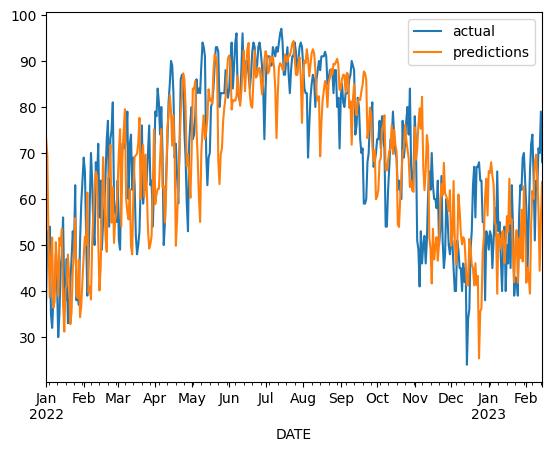

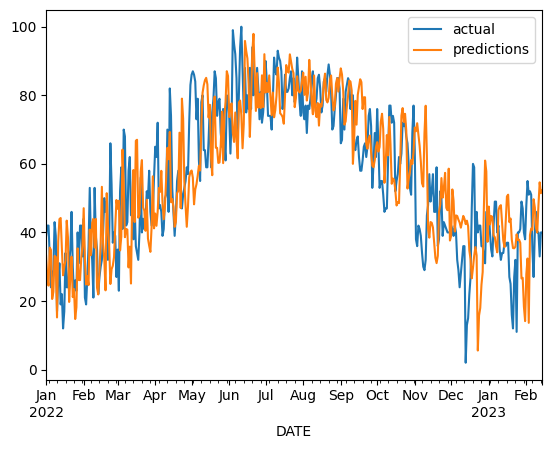

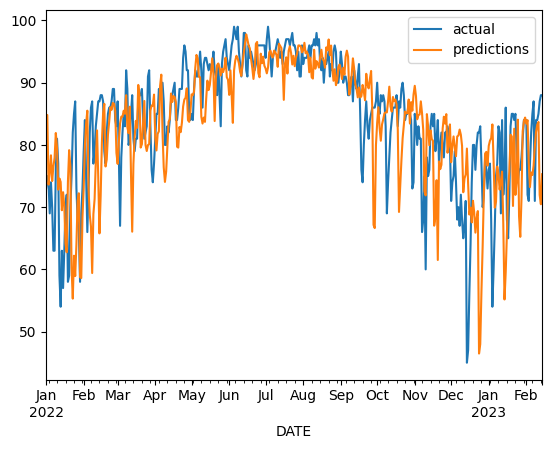

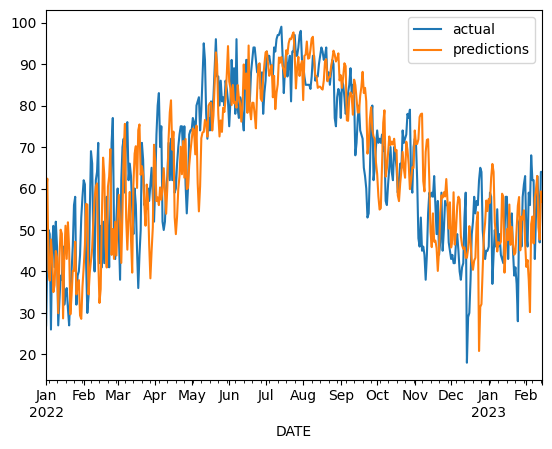

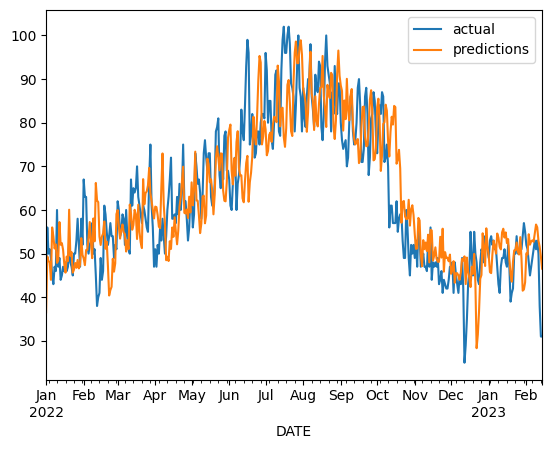

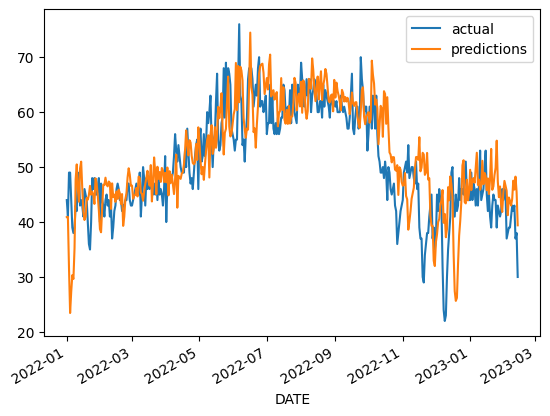

In [28]:
combined_df_10_day = pd.concat([test_set[['name','target_temp_max_day_10']], pd.Series(predictions, index = test_set.index)], axis=1)
combined_df_10_day.columns = ['name','actual','predictions']
combined_df_10_day.groupby(by='name').plot()

In [29]:
#find values that the model predicted incorectly
combined_df_10_day['diff'] = (combined_df_10_day['actual']-combined_df_10_day['predictions']).abs()
combined_df_10_day.sort_values('diff', ascending=False).head()

,name,actual,predictions,diff
DATE,,,,
2022-12-09,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-29.0,18.720461,47.720461
2022-11-10,"MILWAUKEE MITCHELL AIRPORT, WI US",32.0,76.953646,44.953646
2022-12-10,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-32.0,12.686835,44.686835
2022-12-11,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-30.0,13.914035,43.914035
2022-12-08,"FAIRBANKS INTERNATIONAL AIRPORT, AK US",-20.0,23.738237,43.738237
